In [14]:
import pandas as pd
from surprise import SVD
from surprise import Dataset
from surprise import accuracy
from surprise.model_selection import train_test_split
from surprise import KNNBasic,  KNNWithMeans, KNNBaseline
from surprise.model_selection import KFold
from surprise import Reader
from surprise import NormalPredictor
from surprise.model_selection import cross_validate
import matplotlib.pyplot as plt
import seaborn as sns

### Read and impute data 

In [15]:
movies_df =pd.read_csv('data/ml-latest-small/movies.csv')
ratings_df =pd.read_csv('data/ml-latest-small/ratings.csv')
links_df =pd.read_csv('data/ml-latest-small/links.csv')
tags_df =pd.read_csv('data/ml-latest-small/tags.csv')
movies_df['year'] =movies_df.title.apply(lambda x: x [-5:-1] if  x[-5].strip() in ['1','2'] else None)
movie_rat_df = ratings_df.merge(movies_df)

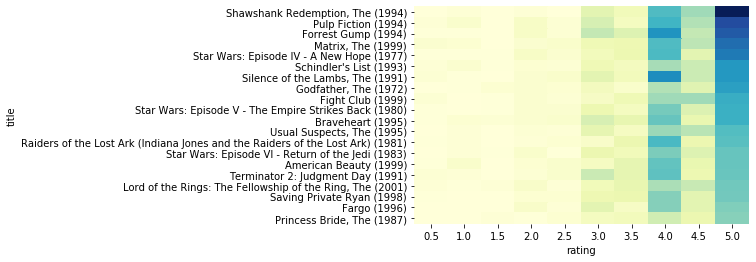

In [16]:
sns.heatmap(pd.crosstab(movie_rat_df.title, movie_rat_df.rating).sort_values(5.0, ascending= False).head(20), 
            cmap="YlGnBu", cbar=False)


#### Prepare Data for modeling

In [17]:
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data = Dataset.load_from_df(ratings_df[['userId', 'movieId', 'rating']], reader)
anti_set = data.build_full_trainset().build_anti_testset()

### Create Basic kmean model 

In [18]:
kf = KFold(n_splits=3)
algo = KNNBasic()
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9528
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9632
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9556


#### make predictions on antiset based on above model 

In [19]:
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)

RMSE: 0.8275


0.8274858160888621

#### Merge predictions with detailed movie dataset 

In [20]:
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)

#### Analysis of predictions 

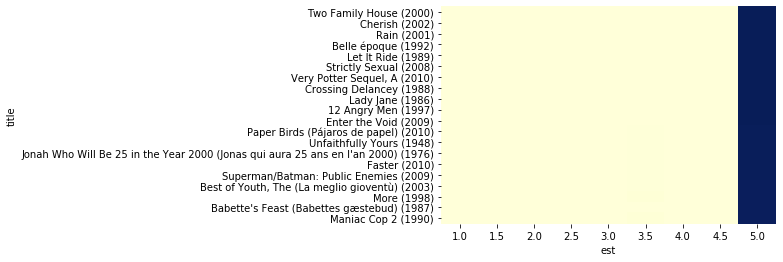

In [21]:
user_pred_df = pd.crosstab(m_df.year, m_df.est)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( user_pred_df.loc['1990':],  cbar=False)
sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

### Analysis with KNN with means

One of the problems with basic knn is that it treats missing ratings as negative rating for that movie if rating skale starts from avalue greater than and we are imputing missing values with zero. 
What we do in this case is to subtract raw mean for user in user item matrix to normalize the data.

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9072
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8984
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9025
RMSE: 0.8071


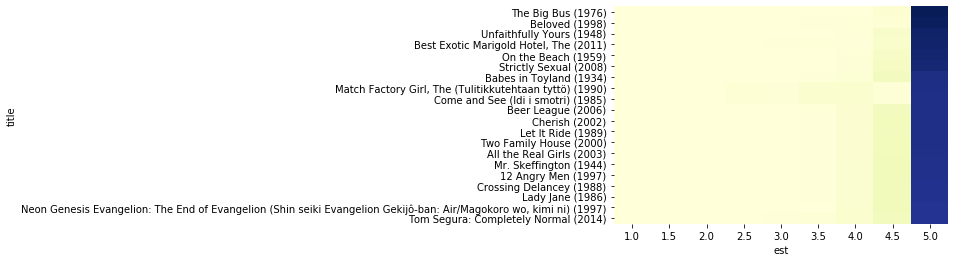

In [22]:
kf = KFold(n_splits=3)
algo = KNNWithMeans()
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)
user_pred_df = pd.crosstab(m_df.year, m_df.est)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( user_pred_df.loc['1990':],  cbar=False)
sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

### Analysis with Knn baseline

KNN with baseline is used to handle the scenario where a new movie is added which is not rated yet. or when a new user is added who has not rated any movie . we use some baseline ratings in such cases. 

Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8720
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8812
Estimating biases using als...
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.8891
RMSE: 0.7689


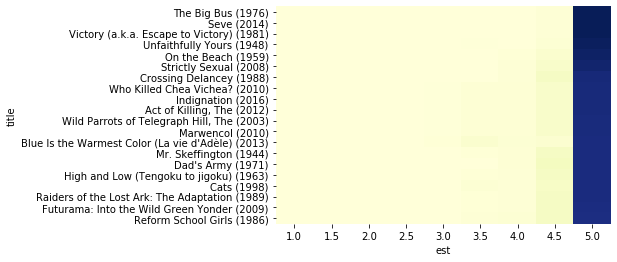

In [23]:
kf = KFold(n_splits=3)
algo = KNNBaseline()
for trainset, testset in kf.split(data):
    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)
    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)
predictions = algo.test(anti_set)
accuracy.rmse(predictions, verbose=True)
pred_df = pd.DataFrame(predictions)
m_df = movies_df.merge(pred_df, left_on = 'movieId', right_on = 'iid')
m_df['est'] =m_df.est.apply(lambda x: (round(x*2))/2)
user_pred_df.sort_values(1.0, ascending = False).head()
sns.heatmap( pd.crosstab(m_df.title, m_df.est).sort_values(5.0, ascending = False).head(20),
            cmap="YlGnBu", cbar=False)

In [ ]:
#### Average Predicted ratings for 1990

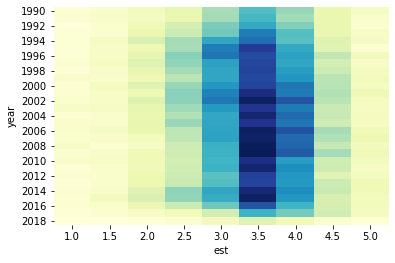

In [27]:
user_pred_df = pd.crosstab(m_df.year, m_df.est)
sns.heatmap( user_pred_df.loc['1990':],  cbar=False, cmap="YlGnBu")

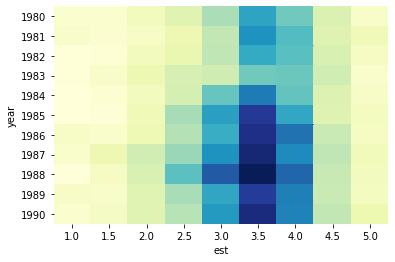

In [35]:
sns.heatmap( user_pred_df.loc['1980':'1990'],  cbar=False, cmap="YlGnBu")

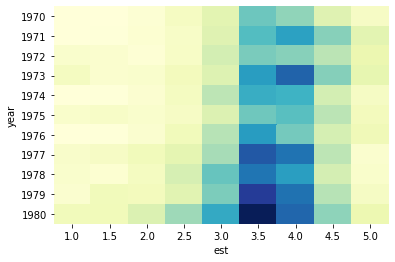

In [36]:
sns.heatmap( user_pred_df.loc['1970':'1980'],  cbar=False, cmap="YlGnBu")

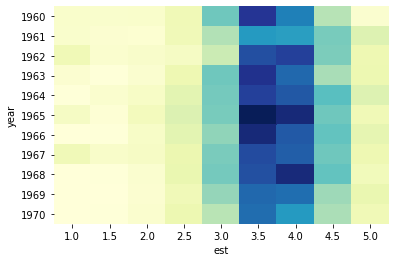

In [30]:
sns.heatmap( user_pred_df.loc['1960':'1970'],  cbar=False, cmap="YlGnBu")

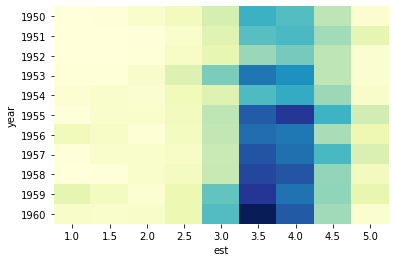

In [31]:
sns.heatmap( user_pred_df.loc['1950':'1960'],  cbar=False, cmap="YlGnBu")

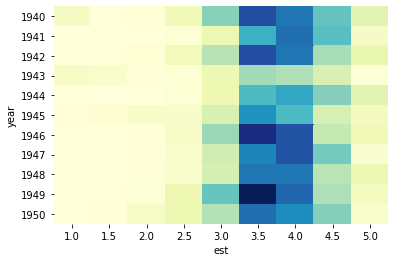

In [32]:
sns.heatmap( user_pred_df.loc['1940':'1950'],  cbar=False, cmap="YlGnBu")

### Analysis of individual user behaviour 

In [40]:
uid_1 = m_df[m_df.uid==1]

In [56]:
uid_1_rat5 = uid_1[uid_1.est==5.0]
uid_1_pred_by_genre= pd.crosstab( uid_1.genres, uid_1.est) 

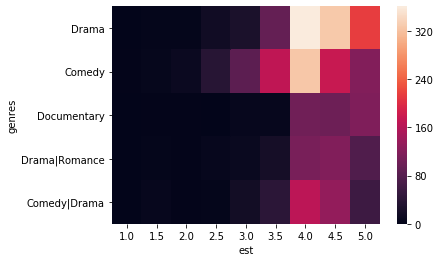

In [57]:
sns.heatmap(uid_1_pred_by_genre.sort_values(5.0, ascending = False).head())

In [60]:
movie_rat_uid_1= movie_rat_df[m_df.uid==1]

/Users/pankaj/anaconda/envs/ML7331/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


In [62]:
movie_rat_uid_1.columns

Index(['userId', 'movieId', 'rating', 'timestamp', 'title', 'genres', 'year'], dtype='object')

In [68]:
movie_rat_uid_1
uid_rat_1_rat5 = movie_rat_uid_1[movie_rat_uid_1.rating==5.0]
uid_1_actual_by_genre= pd.crosstab( movie_rat_uid_1.genres, movie_rat_uid_1.rating) 

In [69]:
uid_1_actual_by_genre.head()

rating,0.5,1.0,1.5,2.0,2.5,3.0,3.5,4.0,4.5,5.0
genres,,,,,,,,,,
Action,0,0,0,0,0,1,0,0,0,0
Action|Adventure,0,0,0,0,0,0,0,1,0,0
Action|Adventure|Comedy,0,0,0,0,1,1,0,0,0,0
Action|Adventure|Comedy|Fantasy|Romance,0,0,0,0,0,0,0,0,1,0
Action|Adventure|Comedy|Sci-Fi,0,0,0,0,0,0,0,0,0,1


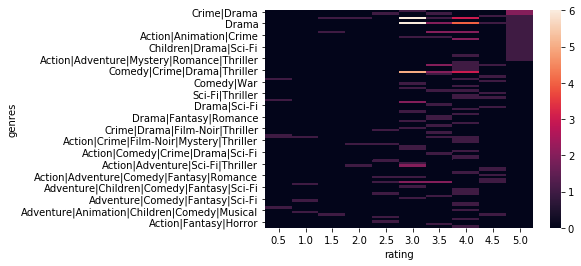

In [70]:
sns.heatmap(uid_1_actual_by_genre.sort_values(5.0, ascending = False))

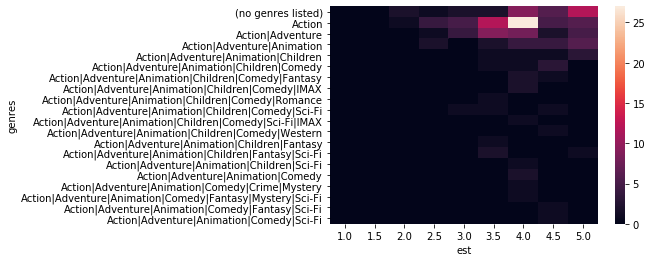

In [72]:
uid_1_rat5 = uid_1[uid_1.est==5.0]
pd.crosstab( uid_1.genres, uid_1.est).sort_values(5.0, ascending = False)
sns.heatmap(pd.crosstab( uid_1.genres, uid_1.est).head(20))

In [44]:
uid_1_rat5.columns

Index(['movieId', 'title', 'genres', 'year', 'uid', 'iid', 'r_ui', 'est',
       'details'],
      dtype='object')